In [1]:
# %pip install -r requirements.txt
# %/Applications/Python\ 3.11/Install\ Certificates.command
# %pip install git+https://github.com/tensorflow/examples.git
# !python3 -m pip install --upgrade pip

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout, Activation
from tensorflow.keras.models import Model
from IPython.display import clear_output
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam


2024-11-02 15:58:57.453677: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
batch_size = 8
learning_rate = 0.001
buffer_size = 3000
image_size = (48, 48)
output_channels = 2
seed = 420
epochs = 64
model_version = 'v0_2'

- v0_1: initial training, verify the model (96, 96)
- v0_2: smaller model (48, 48), less layers

In [4]:
# Normalize the images to [0, 1]
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = tf.cast(input_mask, tf.float32)
  input_mask = tf.where(input_mask >= 1, 1, 0)
  return input_image, input_mask

def parse_image_and_label(image_path, label_path):
    # Read the image and label files
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    label = tf.io.read_file(label_path)
    label = tf.image.decode_jpeg(label, channels=1) # Labels are grayscale

    # Preprocess the images and labels
    image = tf.image.resize(image, image_size)
    label = tf.image.resize(label, image_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    image, label = normalize(image, label)

    return image, label

def create_dataset(data_dir):
    image_dir = os.path.join(data_dir, 'image')
    label_dir = os.path.join(data_dir, 'seg')
    
    # Assuming file names are the same for images and labels
    image_file_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    label_file_paths = sorted([os.path.join(label_dir, fname) for fname in os.listdir(label_dir)])

    dataset = tf.data.Dataset.from_tensor_slices((image_file_paths, label_file_paths))
    dataset = dataset.map(parse_image_and_label)
    
    return dataset

# Create the datasets
train_images = create_dataset('data/train')
test_images = create_dataset('data/val')


In [5]:
train_length = len(train_images)
validation_length = len(test_images)
print(f'train_length: {train_length}')
steps_per_epoch = train_length // batch_size


train_length: 19535


In [6]:
train_batches = (
    train_images
    .cache()
    .shuffle(buffer_size, seed=seed)
    .batch(batch_size)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(batch_size)


In [7]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


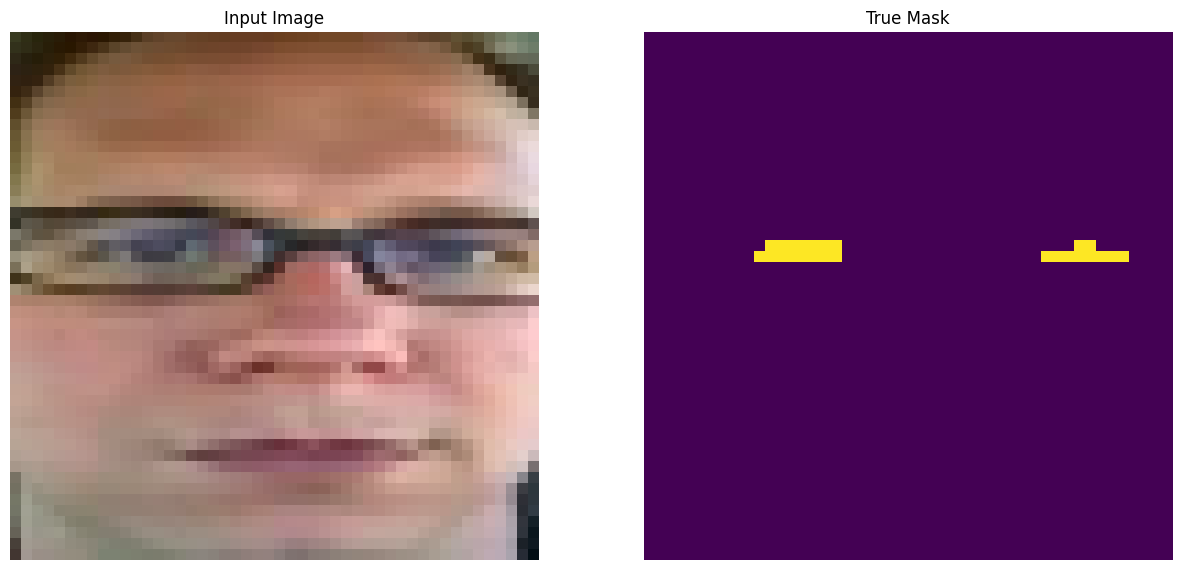

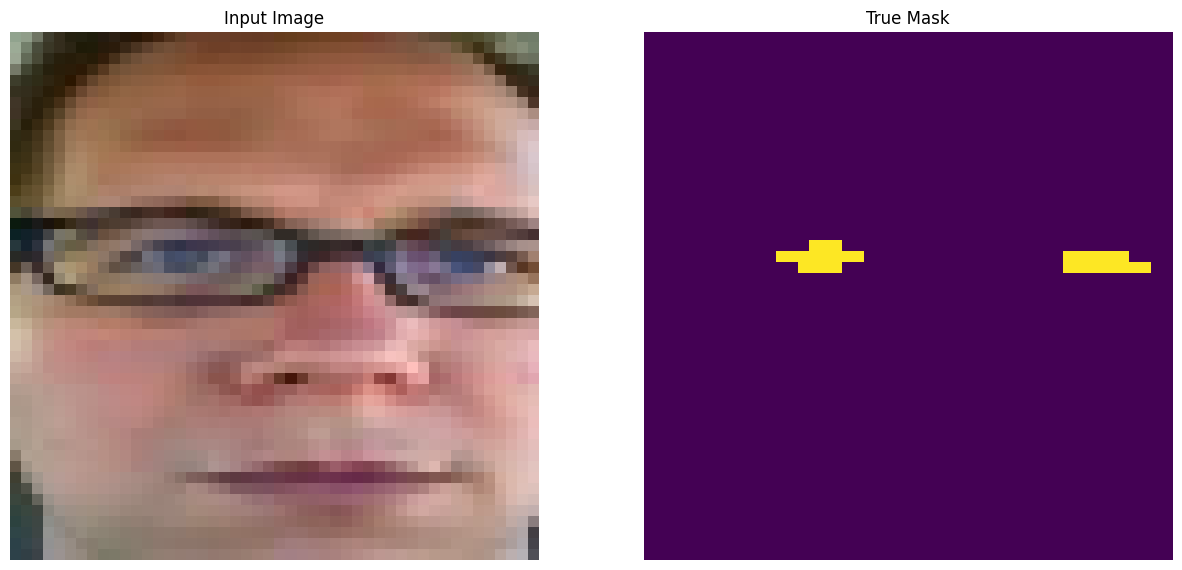

In [8]:
for image, mask in train_images.take(2):
  sample_image, sample_mask = image, mask
  display([sample_image, sample_mask])

In [9]:
def unet_model(input_size=(48, 48, 3)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    # Bottleneck
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    
    # Decoder
    u5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(c5)
    
    u6 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(16, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(16, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(8, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(8, (3, 3), activation='relu', padding='same')(c7)
    
    outputs = Conv2D(2, (1, 1), activation='softmax')(c7)
    
    return Model(inputs, outputs)

In [10]:
model = unet_model(input_size=(image_size[0], image_size[1], 3))

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model.summary()

In [11]:
# tf.keras.utils.plot_model(model)


In [12]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


In [13]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


1/1 [==============================] - 0s 215ms/step


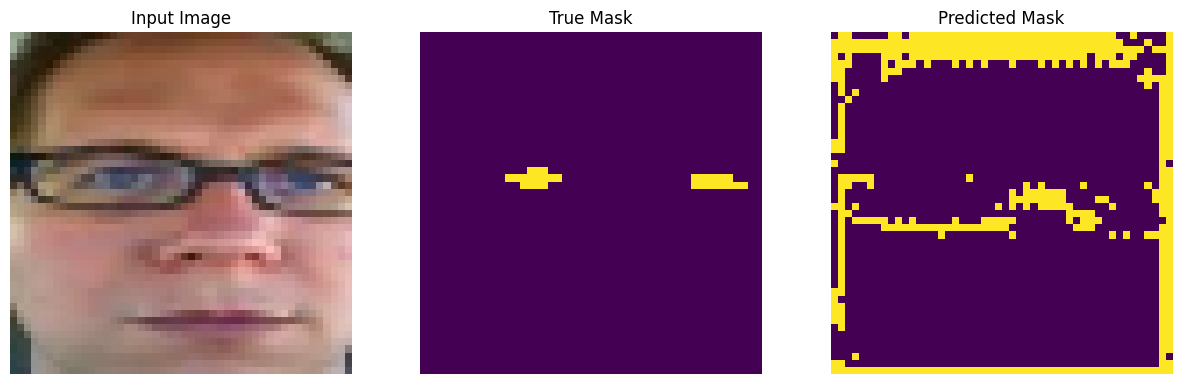

In [14]:
show_predictions()


In [15]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


In [16]:
def lr_schedule(epoch, lr):
    if epoch > 10:
        return lr * 0.5 
    return lr

1/1 [==============================] - 0s 20ms/step


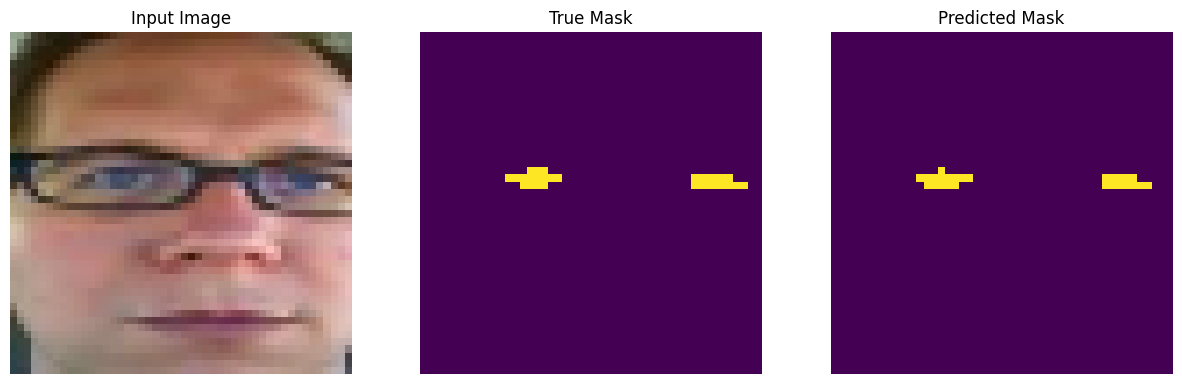


Sample Prediction after epoch 17

2441/2441 [==============================] - 142s 58ms/step - loss: 0.0067 - accuracy: 0.9972 - val_loss: 0.0108 - val_accuracy: 0.9960 - lr: 1.5625e-05


In [17]:
validation_subsplits = 3
validation_steps = validation_length//batch_size//validation_subsplits

lr_scheduler = LearningRateScheduler(lr_schedule)

checkpoint = ModelCheckpoint(filepath='best_model.h5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_history = model.fit(train_batches, epochs=epochs,
                          steps_per_epoch=steps_per_epoch,
                          validation_steps=validation_steps,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback(), lr_scheduler, checkpoint, early_stopping])


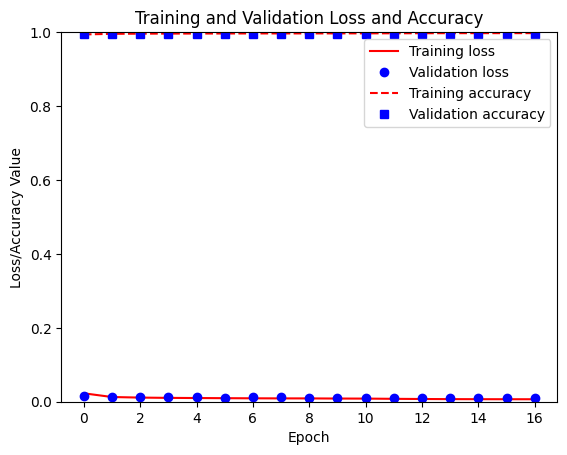

In [18]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

if len(val_loss) < len(loss):
    val_loss += [val_loss[-1]] * (len(loss) - len(val_loss))
if len(val_accuracy) < len(accuracy):
    val_accuracy += [val_accuracy[-1]] * (len(accuracy) - len(val_accuracy))

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.plot(model_history.epoch, accuracy, 'r--', label='Training accuracy')
plt.plot(model_history.epoch, val_accuracy, 'bs', label='Validation accuracy')
plt.title('Training and Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


1/1 [==============================] - 0s 27ms/step


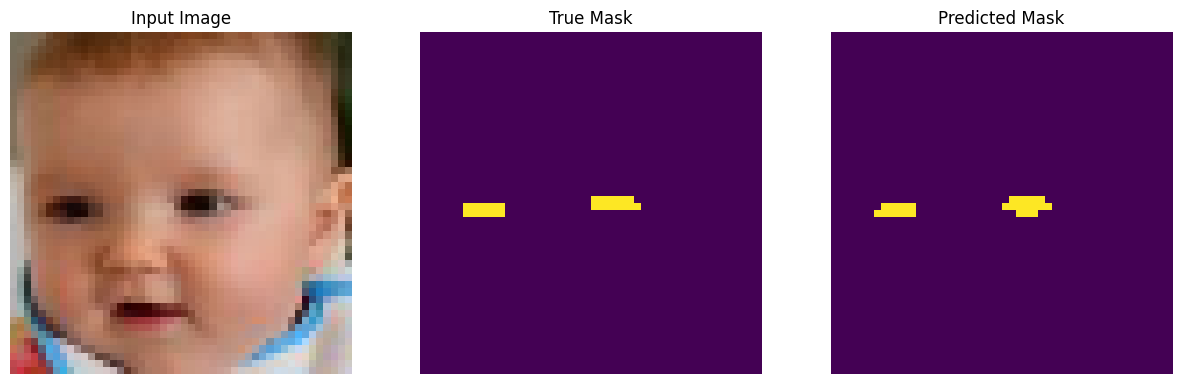

1/1 [==============================] - 0s 21ms/step


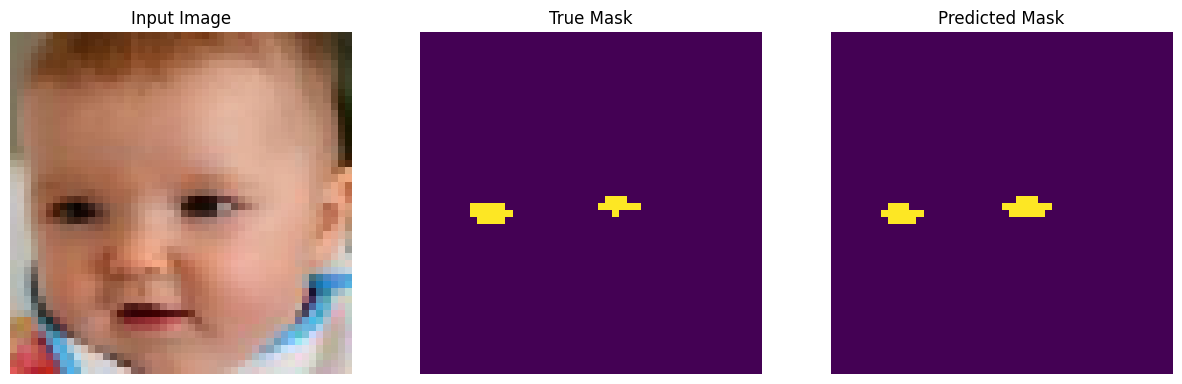

1/1 [==============================] - 0s 21ms/step


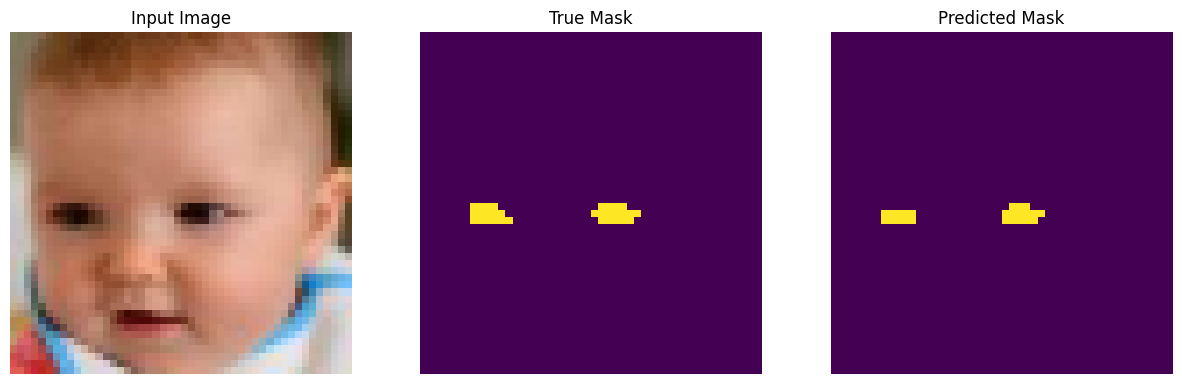

1/1 [==============================] - 0s 23ms/step


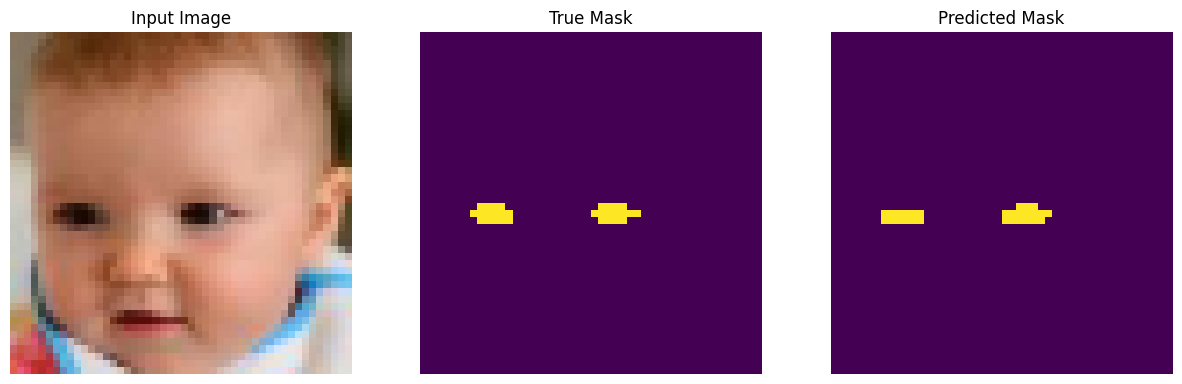

1/1 [==============================] - 0s 22ms/step


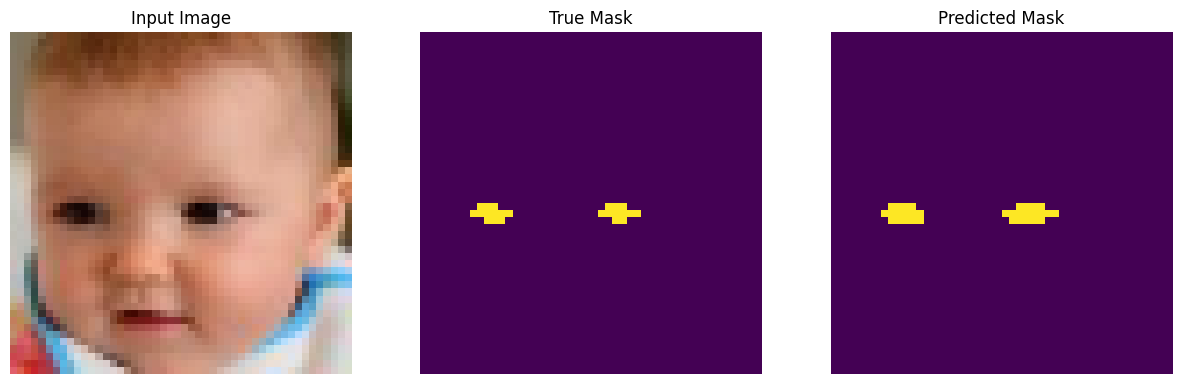

In [19]:
for image, mask in test_images.take(5):
  sample_image, sample_mask = image, mask
  show_predictions()

In [20]:
model.save(f'models/{model_version}.keras')


In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile(f'models/{model_version}.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmpg3088utb/assets


INFO:tensorflow:Assets written to: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmpg3088utb/assets
2024-11-02 16:41:04.297738: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-11-02 16:41:04.297754: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-11-02 16:41:04.298889: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmpg3088utb
2024-11-02 16:41:04.304327: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-11-02 16:41:04.304342: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/h8/1yqbh1px66l_htqzsttx62x80000gn/T/tmpg3088utb
2024-11-02 16:41:04.317872: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-11-02 16:41:04.323538: I tensorflow/cc/saved_model/load